# Gaussian mixture density networks in one dimension
*Thomas Viehmann* <tv@lernapparat.de>

Today we want to implement a simple Gaussian mixture density network. Mixture Density Networks have been introduced by [Bishop](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) in the 1994 article of the same name.

The basic idea is simple: Given some input, say, $x$ we estimate the distribution of $Y | X=x$ as a mixture (in our cse of Gaussians). In mixture density networks, the parameters of the mixture and its components are computed as a neural net. The canonical loss function is the negative log likelihood and we can backpropagate the loss through the parameters to the 

Mixture density models are generative in the sense that you can sample from the estimated distribution $Y | X=x$.

Today we do this in 1d, but one popular application (in fact the one I implemented first) is the handwriting generation mode of [A. Graves: Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

First, we import the world

In [1]:
from matplotlib import pyplot
%matplotlib inline
import torch
import torch.utils.data
import numpy
from torch.autograd import Variable
import IPython

I used [David Ha's example](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) which is almost twice as wiggly as Bishop's original example. Let's have a dataset and a data loader.

I will differ from Ha and Bishop in that I don't start with the case of the distribution to learn being the graph of a function of the condition $x$ (plus error), but we jump right into the non-graphical case.

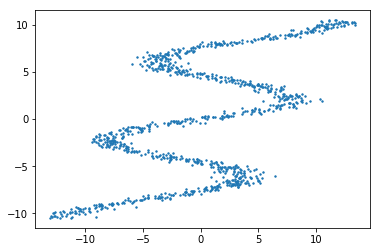

In [2]:
n_train = 1000
batch_size = 32
class DS(torch.utils.data.Dataset):
    def __init__(self, n):
        self.n = n
        self.y = torch.rand(n)*21-10.5
        self.x = torch.sin(0.75*self.y)*7.0+self.y*0.5+torch.randn(n)
    def __len__(self):
        return self.n
    def __getitem__(self,i):
        return (self.x[i],self.y[i])

train_ds = DS(n_train)
pyplot.scatter(train_ds.x.numpy(),train_ds.y.numpy(), s=2)
pyplot.show()
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)

In [3]:
class GaussianMixture1d(torch.nn.Module):
    def __init__(self, n_in, n_mixtures, eps=0):
        super(GaussianMixture1d, self).__init__()
        self.n_in = n_in
        self.eps = eps
        self.n_mixtures = n_mixtures        
        self.lin = torch.nn.Linear(n_in, 3*n_mixtures)
        self.log_2pi = numpy.log(2*numpy.pi)

    def params(self, inp, pi_bias=0, std_bias=0):
        # inp = batch x input
        p = self.lin(inp)
        pi = torch.nn.functional.softmax(p[:,:self.n_mixtures]*(1+pi_bias)) # mixture weights (probability weights)
        mu = p[:,self.n_mixtures:2*self.n_mixtures] # means of the 1d gaussians
        sigma = (p[:,2*self.n_mixtures:]-std_bias).exp() # stdevs of the 1d gaussians
        sigma = sigma+self.eps
        return pi,mu,sigma

    def forward(self, inp, x):
        # x = batch x 3 (=movement x,movement y,end of stroke)
        # loss, negative log likelihood
        pi,mu,sigma = self.params(inp)
        log_normal_likelihoods =  -0.5*((x.unsqueeze(1)-mu) / sigma)**2-0.5*self.log_2pi-torch.log(sigma) # batch x n_mixtures
        log_weighted_normal_likelihoods = log_normal_likelihoods+pi.log() # batch x n_mixtures
        maxes,_ = log_weighted_normal_likelihoods.max(1)
        mixture_log_likelihood = (log_weighted_normal_likelihoods-maxes.unsqueeze(1)).exp().sum(1).log()+maxes # log-sum-exp with stabilisation
        neg_log_lik = -mixture_log_likelihood
        return neg_log_lik

    def predict(self, inp, pi_bias=0, std_bias=0):
        # inp = batch x n_in
        pi,mu,sigma = self.params(inp, pi_bias=pi_bias, std_bias=std_bias)
        x = inp.data.new(inp.size(0)).normal_()
        mixture = pi.data.multinomial(1)       # batch x 1 , index to the mixture component
        sel_mu = mu.data.gather(1, mixture).squeeze(1)
        sel_sigma = sigma.data.gather(1, mixture).squeeze(1)
        x = x*sel_sigma+sel_mu
        return Variable(x)

class Model(torch.nn.Module):
    def __init__(self, n_inp = 1, n_hid = 24, n_mixtures = 24):
        super(Model, self).__init__()
        self.lin = torch.nn.Linear(n_inp, n_hid)
        self.mix = GaussianMixture1d(n_hid, n_mixtures)
    def forward(self, inp, x):
        h = torch.tanh(self.lin(inp))
        l = self.mix(h, x)
        return l.mean()
    def predict(self, inp, pi_bias=0, std_bias=0):
        h = torch.tanh(self.lin(inp))
        return self.mix.predict(h, std_bias=std_bias, pi_bias=pi_bias)


1990 1.3623580932617188


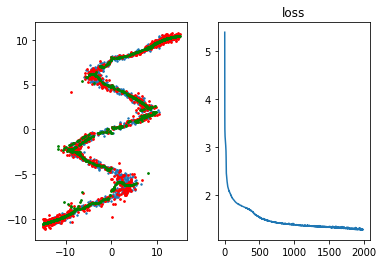

In [4]:
m = Model(1, 32, 20)     
opt = torch.optim.Adam(m.parameters(), 0.001)
m.cuda()
losses = []
for epoch in range(2000):
    thisloss  = 0
    for i,(x,y) in enumerate(train_dl):
        x = Variable(x.float().unsqueeze(1).cuda())
        y = Variable(y.float().cuda())
        opt.zero_grad()
        loss = m(x, y)
        loss.backward()
        thisloss += loss.data[0]/len(train_dl)
        opt.step()
    losses.append(thisloss)
    if epoch % 10 == 0:
        IPython.display.clear_output(wait=True)
        print (epoch, loss.data[0])
        x = Variable(torch.rand(1000,1).cuda()*30-15)
        y = m.predict(x)
        y2 = m.predict(x, std_bias=10)
        pyplot.subplot(1,2,1)
        pyplot.scatter(train_ds.x.numpy(),train_ds.y.numpy(), s=2)
        pyplot.scatter(x.data.cpu().squeeze(1).numpy(), y.data.cpu().numpy(),facecolor='r', s=3)
        pyplot.scatter(x.data.cpu().squeeze(1).numpy(), y2.data.cpu().numpy(),facecolor='g', s=3)
        pyplot.subplot(1,2,2)
        pyplot.title("loss")
        pyplot.plot(losses)
        pyplot.show()


Not bad!
The green line basically gives the means of the mixture components rather than drawing from the mixture. This is implemented by biasing the variance. In some applications we might want to "clean" the output but not disable stochasticity completely. This can be achieved by biasing the variance of the components and biasing the component probabilites towards the largest one in the softmax.
I learnt this trick from  Gaves' article.

## Alternatives? Trying a GAN approach.

We might also try to reproduce a SLOGAN (Single sided Lipschitz Objective General Adversarial Network).
Note that while the MDN above tries to learn the distribution of $y$ given $x$, the GAN below tries to learn the unconditional distribution of pairs $(x,y)$.

I wrote a bit about the Wasserstein GAN in two [blog](https://lernapparat.de/improved-wasserstein-gan/) [posts](https://lernapparat.de/more-improved-wgan/).

In [5]:
class G(torch.nn.Module):
    def __init__(self, n_random=2, n_hidden=50):
        super(G, self).__init__()
        self.n_random = n_random
        self.l1 = torch.nn.Linear(n_random,n_hidden)
        self.l2 = torch.nn.Linear(n_hidden,n_hidden)
        self.l2b = torch.nn.Linear(n_hidden,n_hidden)
        self.l3 = torch.nn.Linear(n_hidden,2)
    def forward(self, batch_size=32):
        x = Variable(self.l1.weight.data.new(batch_size, self.n_random).normal_())
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = torch.nn.functional.relu(self.l2b(x))
        x = self.l3(x)
        return x

class D(torch.nn.Module):
    def __init__(self, lam=10.0, n_hidden=50):
        super(D, self).__init__()
        self.l1 = torch.nn.Linear(2,n_hidden)
        self.l2 = torch.nn.Linear(n_hidden,n_hidden)
        self.l3 = torch.nn.Linear(n_hidden,1)
        self.one = torch.FloatTensor([1]).cuda()
        self.mone = torch.FloatTensor([-1]).cuda()
        self.lam = lam
    def forward(self, x):
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = self.l3(x)
        return x
    def slogan_loss_and_backward(self, real, fake):
        self.zero_grad()
        f_real = self(real.detach())
        f_real_sum = f_real.sum()
        f_real_sum.backward(self.one, retain_graph=True)
        f_fake = self(fake.detach())
        f_fake_sum = f_fake.sum()
        f_fake_sum.backward(self.mone, retain_graph=True)
        f_mean = (f_fake_sum+f_real_sum)
        f_mean.abs().backward(retain_graph=True)
        dist = ((real.view(real.size(0),-1).unsqueeze(0)-fake.view(fake.size(0),-1).unsqueeze(1))**2).sum(2)**0.5
        f_diff = (f_real.unsqueeze(0)-f_fake.unsqueeze(1)).squeeze(2).abs()
        lip_dists = f_diff/(dist+1e-6)
        lip_penalty = (self.lam * (lip_dists.clamp(min=1)-1)**2).sum()
        lip_penalty.backward()
        return f_real_sum.data[0],f_fake_sum.data[0],lip_penalty.data[0], lip_dists.data.mean()

d = D()
d.cuda()
g = G(n_random=20, n_hidden=50)
g.cuda()
opt_d = torch.optim.Adam(d.parameters(), lr=3e-3)
opt_g = torch.optim.Adam(g.parameters(), lr=3e-3)


9500


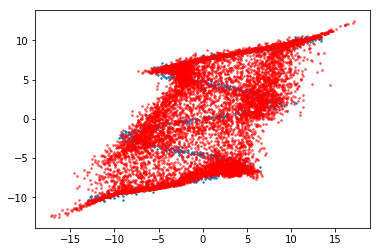

f_r: -21.730976104736328 f_fake: 9.173234939575195 lip loss: 2.604095935821533 lip_mean 0.12078490853309631
f_r: -34.528541564941406 f_fake: 26.048871994018555 lip loss: 1.6838256120681763 lip_mean 0.1639532744884491
f_r: -21.662294387817383 f_fake: 28.168577194213867 lip loss: 1.19843327999115 lip_mean 0.14067403972148895
f_r: -34.43589782714844 f_fake: 26.15525245666504 lip loss: 0.3776635527610779 lip_mean 0.15872517228126526
f_r: -24.741670608520508 f_fake: 19.509538650512695 lip loss: 0.9746809005737305 lip_mean 0.13982835412025452
f_r: -29.979442596435547 f_fake: 18.58690071105957 lip loss: 1.57478666305542 lip_mean 0.1497378796339035
f_r: -24.721054077148438 f_fake: 19.418386459350586 lip loss: 0.6823129653930664 lip_mean 0.14315637946128845
f_r: -30.01385498046875 f_fake: 13.168084144592285 lip loss: 2.589550733566284 lip_mean 0.15334050357341766
f_r: -24.686494827270508 f_fake: 23.508073806762695 lip loss: 0.8718420267105103 lip_mean 0.13491739332675934
f_r: -11.24134540557861

In [6]:

def endless(dl):
    while True:
        for i in dl:
            yield i

batch_size=64
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
train_iter = endless(train_dl)

for i in range(10000):
    if i>0 and i%1000 == 0:
        for pg in opt_g.param_groups:
            pg['lr'] /= 3
        for pg in opt_d.param_groups:
            pg['lr'] /= 3
        print ("new lr",pg['lr'])
    for j in range(100 if i < 10 or i % 100 == 0 else 10):
        g.eval()
        d.train()
        for p in d.parameters():
            p.requires_grad = True
        real_x,real_y = next(train_iter)
        real = Variable(torch.stack([real_x.float().cuda(), real_y.float().cuda()],dim=1))
        fake = g(batch_size=batch_size)
        l_r, l_f, l_lip, lip_mean = d.slogan_loss_and_backward(real, fake)
        opt_d.step()
    if i % 20 == 0:
        print ("f_r:",l_r,"f_fake:",l_f, "lip loss:", l_lip, "lip_mean", lip_mean)
    g.train()
    d.eval()
    for p in d.parameters():
        p.requires_grad = False
    g.zero_grad()
    fake = g(batch_size=batch_size)
    f = d(fake)
    fsum = f.sum()
    fsum.backward()
    opt_g.step()
    if i % 500 == 0:
        IPython.display.clear_output(wait=True)
        print (i)
        fake = g(batch_size=10000)
        pyplot.scatter(train_ds.x.numpy(),train_ds.y.numpy(), s=2)
        pyplot.scatter(fake.data[:,0].cpu().numpy(), fake.data[:,1].cpu().numpy(), facecolor='r',s=3, alpha=0.5)
        pyplot.show()

We can try to see where $f$ sees the most discriminative power between the real sample and the generated fake distribution. Note that as $f$ depends on both distributions, it is not as simple as $f$ is low on the real data.

While we are far from perfectly resolving the path, it does not look too bad, either.

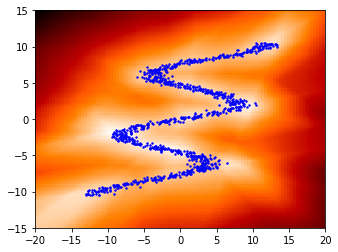

In [7]:
N_dim = 100
x_test = torch.linspace(-20,20, N_dim)
y_test = torch.linspace(-15,15, N_dim)
x_test = (x_test.unsqueeze(0)*torch.ones(N_dim,1)).view(-1)
y_test = (y_test.unsqueeze(1)*torch.ones(1,N_dim)).view(-1)
xy_test = Variable(torch.stack([x_test, y_test], dim=1).cuda())
f_test = d(xy_test)
pyplot.imshow(f_test.data.view(N_dim,N_dim).cpu().numpy(), origin='lower', cmap=pyplot.cm.gist_heat_r, extent=(-20,20,-15,15))
pyplot.scatter(train_ds.x.numpy(),train_ds.y.numpy(), facecolor='b', s=2)



While it seems that most of the red dots are concentrated new the blue sample, there are not only deviations, but also parts of the sample distribution that (in particular the middle row). I have run a few variations to see if it can be easily helped, but this does not seem to be the case.
Note that the discriminator does seem to be able to reasonably resolve the shape, but apparently the generator does not learn it properly. [Bellemare et al](https://arxiv.org/abs/1705.10743) suggest that the effect may originate with bias in the stochastic gradient of the Wassestein distance.

This is all for today. Be sure to write me if you improve on the GAN result.

I appreciate your feedback at <tv@lernapparat.de>.